# Preprocessing

In [3]:
data_dir = ''  # ссылка на папку internship_data
# если поместить ноутбук в intership_data, то оставить пустую строку

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def create_csv(data_dir):
    """
    Вход: директория с датасетом (папка intership_data)
    Выход: csv таблица с путями файлов и классами
    """
    files = []
    labels = []
    male_listdir = os.listdir(os.path.join(data_dir, 'male'))
    female_listdir = os.listdir(os.path.join(data_dir, 'female'))
    
    for el in male_listdir:
        if el[-3:] == 'jpg':
            files.append('male/' + el)
            labels.append(0)
    
    for el in female_listdir:
        if el[-3:] == 'jpg':
            files.append('female/' + el)
            labels.append(1)

    data = pd.DataFrame() 

    labels = pd.Series(labels, name='label')
    paths = pd.Series(files, name='path')
    data = pd.concat((data, paths, labels), axis=1)

    data = data.sample(frac=1).reset_index(drop=True)  # перемешиваем данные
    data.to_csv(os.path.join(data_dir, 'data.csv'), index=False)  # сохраняем таблицу
    
    return data

In [4]:
create_csv(data_dir)

,path,label
0,female/100684.jpg,1
1,male/022461.jpg,0
2,male/114814.jpg,0
3,male/107015.jpg,0
4,female/075438.jpg,1
...,...,...
99997,female/048088.jpg,1
99998,female/006147.jpg,1
99999,male/048992.jpg,0
100000,female/112241.jpg,1


In [5]:
df = pd.read_csv(os.path.join(data_dir, 'data.csv'))
X = df.path.values
y = df.label.values

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [70000, 85000])  # разбиваем датасет: 70 000 train, по 15 000 val и test

X_train, y_train = X[tr], y[tr]
X_val, y_val = X[val], y[val]
X_test, y_test = X[ts], y[ts]

In [7]:
import torch
import albumentations
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from torch.utils.data import Dataset, DataLoader

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')  # включаем поддержку GPU
device

'cuda:0'

In [8]:
class FaceDataset(Dataset):
    """
    Итерируемый класс датасета. С помощью него мы можем обращаться к данным как к итерируемому объекту. 
    """
    def __init__(self, path, labels, data_dir):
        """
        path - пути к фото
        labels - классы
        data_dir - путь к директории датасета
        """
        self.X = path
        self.y = labels
        self.data_dir = data_dir
        self.aug = albumentations.Compose([
            albumentations.Resize(224, 224, always_apply=True),
            albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225], always_apply=True)
        ])  # ресайз и нормализация к ImageNet
       
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        """
        Вход: индекс
        Выход: соответствующее индексу фото и класс в формате torch.tensor 
        """
        image = Image.open(os.path.join(self.data_dir, self.X[i]))  # загружаем фото в RAM
        image = self.aug(image=np.array(image))['image']  # редактируем
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # меняем каналы под формат pytorch (channels, H, W)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [9]:
train_data = FaceDataset(X_train, y_train, data_dir)
val_data = FaceDataset(X_val, y_val, data_dir)
test_data = FaceDataset(X_test, y_test, data_dir)
 
# dataloaders - с помощью нашего класса датасета сэмплируют данные в батчи
BATCH_SIZE = 100
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [10]:
net = models.resnet18(pretrained=True).to(device)  # загружаем предобученную на ImageNet resnet18 сразу на GPU
net.fc = nn.Linear(512, 2).to(device)  # ставим выходной слой на 2 класса

for param in net.parameters():
    param.requires_grad = False  # выключаем градиенты по всей сети
    
for param in net.fc.parameters():  # включаем последний слой (классификатор)
    param.requires_grad = True
    
for param in net.layer4.parameters():  # включаем 4, 3 и 2 слои
    param.requires_grad = True
    
for param in net.layer3.parameters():
    param.requires_grad = True
    
for param in net.layer2.parameters():
    param.requires_grad = True

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
def train(model, device, loss_fn, optimizer, train_loader, val_loader, num_epoch):
    train_losses = []
    test_losses = []
    accuracy = []

    for i in range(num_epoch):
        epoch_train_losses = []
        model.train(True)
        for X_train, y_train in tqdm(train_loader):
            # Посчитаем предсказание и лосс
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)

            # зануляем градиент
            optimizer.zero_grad()

            # backward
            loss.backward()

            # ОБНОВЛЯЕМ веса
            optimizer.step()

            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.item())   
                    
        train_losses.append(np.mean(epoch_train_losses))
        
        # Теперь посчитаем лосс на вал
        model.eval()
        with torch.no_grad():
            epoch_test_losses = []
            epoch_accuracy = []
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                loss = loss_fn(y_pred, y_val)
            
                epoch_test_losses.append(loss.item())
                epoch_accuracy.append(accuracy_score(y_pred.cpu().max(1)[1], y_val.cpu()))

            test_losses.append(np.mean(epoch_test_losses))
            accuracy.append(np.mean(epoch_accuracy))
            
            torch.save(model.state_dict(), f'epoch_{i}.pth')  # сохраняем веса эпох

            print(
                'Train loss =', train_losses[-1],
                'Val loss =', test_losses[-1],
                'Val accuracy =', accuracy[-1]
            )
            
    return train_losses, test_losses, accuracy

In [75]:
optimizer = optim.AdamW(net.parameters(), amsgrad=True)  
criterion = nn.CrossEntropyLoss()

In [76]:
train_losses, val_losses, accuracy = train(net, device, criterion, optimizer, trainloader, valloader, 6)

  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Train loss = 0.0895881350032453 Val loss = 0.07342546665420135 Val accuracy = 0.9721999999999998


  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Train loss = 0.05115799827634224 Val loss = 0.06463806412182749 Val accuracy = 0.9759333333333332


  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Train loss = 0.03781166674319788 Val loss = 0.06056917899288237 Val accuracy = 0.9782000000000001


  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Train loss = 0.02467738921986893 Val loss = 0.05527400261024013 Val accuracy = 0.9813333333333333


  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Train loss = 0.01887604011522074 Val loss = 0.07049495521389569 Val accuracy = 0.9779333333333333


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [09:23<00:00,  1.24it/s]


Train loss = 0.012060609979619455 Val loss = 0.07070747592719272 Val accuracy = 0.9811999999999999


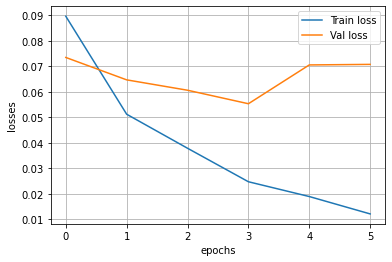

In [82]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Val loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.grid()
plt.legend()
plt.show()

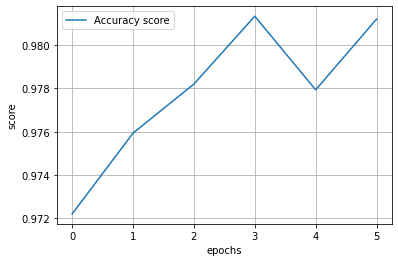

In [83]:
plt.plot(accuracy, label='Accuracy score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.grid()
plt.legend()
plt.show()

In [13]:
def test_model(model, test_loader):
    """
    Вход: модель и даталоадер
    Выход: accuracy score на данных из даталоадера
    """
    model.eval()
    with torch.no_grad():
        preds = np.empty(0)
        labels = np.empty(0)
        for X, y in tqdm(test_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            preds = np.concatenate((preds, y_pred.max(1)[1].cpu()))
            labels = np.concatenate((labels, y.cpu()))
    return accuracy_score(labels, preds)

In [16]:
net.load_state_dict(torch.load('epoch_3.pth'))  # загружаю веса самой удачной четвертой эпохи

<All keys matched successfully>

In [17]:
test_model(net, testloader)  # считаем метрику на тестовых данных

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [01:23<00:00,  1.81it/s]


0.9916011198506866